In [1]:
# Set up working environment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np
import os
import shutil
import maboss
#import ginsim

## Toy model at the single-cell level

The following introduces a toy model accounting for differentation process in two cell types T1 and T2: 
    an input node I activate a node A drive the cell in type T1; 
    in parralel, the node A activate a ligand L, that will trigger a receptor R that drives the cell in type T2. 
    To avoid cross cell types, T2 is only activated without A and T1 is only activated when cell in not in type T2.

In [2]:
# Set up the required files
bnd_file ="ToyModelUP.bnd"
cfg_file = "ToyModelUP.cfg"

In [3]:
model_maboss = maboss.load(bnd_file,cfg_file)
# maboss.set_output(model_maboss, ["T", "A", "B", "C", "R"])
model_maboss.print_bnd()

Node I {


	rate_up = 0.0;
	rate_down = 0.0;
}
Node A {


	rate_up = I ? 1.0 : 0.0;
	rate_down = 0.0;
}

Node L {


	rate_up = A ? 1.0 : 0.0;
	rate_down = 0.0;
}

Node R {


	rate_up = $innerOn ? L : $outerL;
	rate_down = 0.0;
}

Node T1 {


	rate_up = (A & (!T2)) ? 1.0 :0.0;
	rate_down = 0.0;
}

Node T2 {


	rate_up = (R & (!A)) ? 1.0 : 0.0;
	rate_down = 0.0;
}


The MaBoSS simulation, without the ligand-receptor activation, produces only type T1 cells.

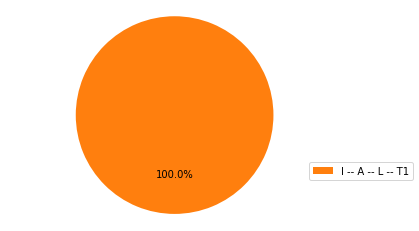

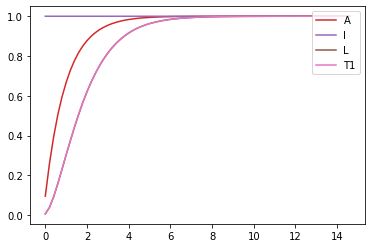

In [4]:
r = model_maboss.run()

# Plot the piechart and trajectories
r.plot_piechart()
r.plot_node_trajectory(until=15)

# save pdf versions of the plots
r._piefig.savefig("single_pie.pdf")
r._ndtraj.savefig("single_traj.pdf")

If we switch on the activation of L by R in the MaBoSS model, we still don't get T2 cell type.

In [5]:
model_maboss_innerOn = maboss.copy_and_update_parameters(model_maboss,{"$innerOn":1})
model_maboss_innerOn.print_cfg()

$nb_mutable = 0;
$innerOn = 1;
$outerL = 0;
[I].istate = 0[0] , 1[1];
[A].istate = 1[0] , 0[1];
[L].istate = 1[0] , 0[1];
[R].istate = 1[0] , 0[1];
[T1].istate = 1[0] , 0[1];
[T2].istate = 1[0] , 0[1];

time_tick = 0.2;
max_time = 15.0;
sample_count = 100000.0;
discrete_time = 0.0;
use_physrandgen = 1;
seed_pseudorandom = 0.0;
display_traj = 0.0;
statdist_traj_count = 0.0;
statdist_cluster_threshold = 1.0;
thread_count = 1.0;
statdist_similarity_cache_max_size = 20000.0;
I.is_internal = False;
A.is_internal = False;
L.is_internal = False;
R.is_internal = False;
T1.is_internal = False;
T2.is_internal = False;



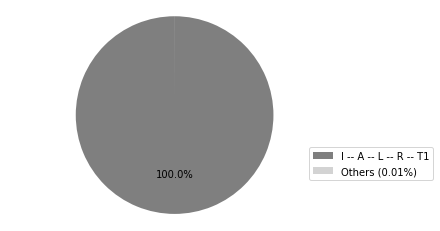

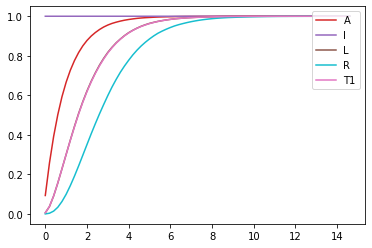

In [6]:
r_iOn = model_maboss_innerOn.run()

# Plot the piechart and trajectories
r_iOn.plot_piechart()
r_iOn.plot_node_trajectory(until=15)

# save pdf versions of the plots
r_iOn._piefig.savefig("single_pie_iOn.pdf")
r_iOn._ndtraj.savefig("single_traj_iOn.pdf")

## Add rules for the population

Here we extend the previous model to take into account an additional population effect: when a cell produces L, it 
    can be secreted and act on neighbour cells as well (through receptor R).
As these other cells may not have an active A component, R will then be able to activate T2 in these cells.

In [7]:
upp_file = "ToyModelUP.upp"
model_maboss.update_parameters(max_time=.5)
model_upmaboss = maboss.UpdatePopulation(model_maboss, upp_file)
ufile = open(upp_file, 'r') 
print(ufile.read())
ufile.close()

$outerL u= 5*p[(L) = (1)];
steps = 15;
MaBoSS = MaBoSS;


CPU times: user 83.2 ms, sys: 112 ms, total: 195 ms
Wall time: 15.4 s


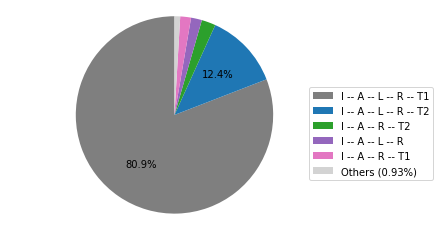

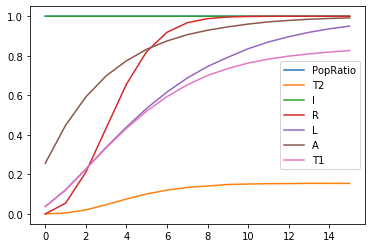

In [8]:

#model_upmaboss.setStepNumber(100)
%time ur = model_upmaboss.run()

ur.results[-1].plot_piechart()
ur.results[-1]._piefig.savefig("fast_pop_pie.pdf")

traj = ur.get_nodes_stepwise_probability_distribution()
p = traj.plot()
p.get_figure().savefig("fast_pop_traj.pdf")